## PCA and Text Analysis

This assignment involves processing real e-mails, some of which are scams. 

Fair warning: Some of these scam e-mails have offensive content. If you start reading the e-mail text or the token data, you might read something offensive. If that's a problem, feel free to e-mail me, and we can talk about it and discuss how to proceed with alternative tasks.

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow
import ast

### Q1. 

**Tokens**: The individual words or symbols that create text data like emails. Natural Language Processing is primarily about analyzing the frequency and co-occurrence of tokens.

I aggregated all the emails into a single vector, and removed the punctuation and very common words (e.g. "the"). Run the below code chunk to open it, and use the Counter class to look at the most common words:

***I used ML to refine my code / assist with errors***

In [80]:
import pickle
with open('data/all_tokens.pickle', 'rb') as file:
    all_tokens = pickle.load(file)
    
from collections import Counter
token_count = Counter(all_tokens)
token_freq = token_count.most_common(100)
print(token_count.most_common(5))

[('new', 1365), ('date', 1202), ('get', 1052), ('please', 1022), ('enron', 927)]


Plot a histogram of the occurrences of tokens. 

What do you notice about the frequency of occurrence of different tokens? How does it look?

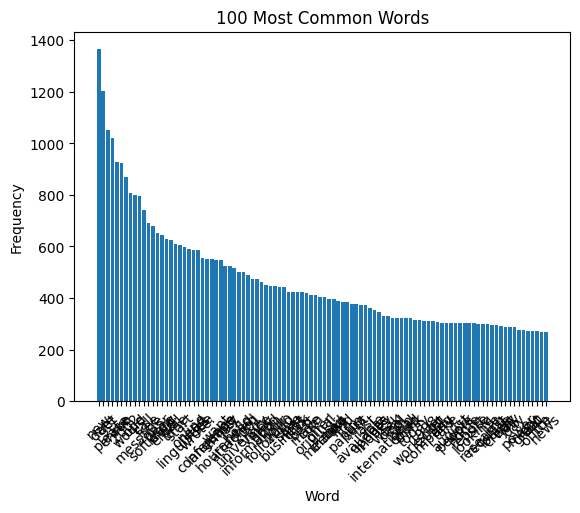

In [81]:
words = [w for w, c in token_freq]
counts = [c for w, c in token_freq]

plt.bar(words, counts)
plt.xticks(rotation=45)
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.title("100 Most Common Words")
plt.show()

The trend of the histogram shows that there are a few words that appear with very high frequency (such as "new","date", or "get"). However, the histogram shows that as you move down the most to least common words, the frequency of each word sharply declines, and then begins to even out. The growth appears to be something like exponential decay. 

### Q2. 

Load `Phishing_clean.parquet`. This is the text from the e-mails broken into the most common 2,711 tokens and one-hot-encoded as features/covariates. So each row is an e-mail, the `Email Type` takes the value 1 if it's a scam and 0 otherwise, and every other column is a word or symbol that occurs in at least 15 e-mails.

1. Perform an 80/20 train-test split of the data.
2. Run a regression of $y$ on the one-hot-encoded emails. What is the $R^2$ on the test set? On the training set?
3. What words have the largest coefficients in absolute value and most strongly influence predictions? 

In [82]:
df = pd.read_parquet("data/Phishing_clean.parquet")
df = df.dropna()
print(df.tail())

       Email Type  new  date  get  please  enron  like  2002  would  one  ...  \
18629           1    0     1    0       0      0     0     0      0    0  ...   
18630           0    0     0    0       1      1     0     0      0    0  ...   
18631           0    0     0    0       0      0     0     0      0    0  ...   
18632           0    0     0    0       1      0     0     0      0    0  ...   
18633           1    0     0    0       0      0     0     0      0    0  ...   

       ï¿½ï¿½  safety  yap  ypil  maintain  procedures  tip  elizabeth  \
18629       0       0    0     0         0           0    0          0   
18630       0       0    0     0         0           0    0          0   
18631       0       0    0     0         0           0    0          0   
18632       0       0    0     0         0           0    0          0   
18633       0       0    0     0         0           0    0          0   

       leadership  italian  
18629           0        0  
18630     

80/20 train-test split of the data

In [83]:
def maxmin(z):
    w = (z-np.min(z))/(np.max(z)-np.min(z))
    return w

y = df['Email Type'] # Create target variable vector
X = df.drop('Email Type', axis=1) # Create feature matrix

# Split the sample:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, # Feature and target variables
                                                    test_size=.2, # Split the sample 80 train/ 20 test
                                                    random_state=65) # For replication purposes

In [84]:
from sklearn.linear_model import LinearRegression # Import linear regression model

reg = LinearRegression(fit_intercept=False).fit(X_train, y_train) # Fit the linear model
r2_train = reg.score(X_train, y_train)
r2_test = reg.score(X_test, y_test)

print(f"R² (train): {r2_train:.4f}")
print(f"R² (test): {r2_test:.4f}")

R² (train): 0.6963
R² (test): 0.5643


In [85]:
results = pd.DataFrame({'variable':reg.feature_names_in_, 'coefficient': reg.coef_})
results["abs_coefficient"] = results["coefficient"].abs()
results = results.sort_values(by="abs_coefficient", ascending=False)
print(results.head(5))

     variable  coefficient  abs_coefficient
906     aging     1.093989         1.093989
2362  thermal     0.981544         0.981544
2532   xanaax     0.885411         0.885411
2701   ï¿½ï¿½     0.883589         0.883589
2058    12px;     0.806269         0.806269


### Q3. 

Take the matrix of one-hot-encoded tokens (the data, less the outcome variable, `Email Type`) and perform a principal components analysis decomposition with two components. Plot the first two principal components in a scatter plot, and hue the points by whether they are a phishing scam or not. Do you notice any patterns?

In [86]:
# take X and perform a principal component analysis (pca decomposition) with 2 components

def demean(x):
    xbar = np.mean(x)
    z = x-xbar
    return(z)

Z = X.apply(demean) # Z is the demeaned X
X_mean = X.mean().to_numpy() # Compute variable averages

print('Dimensions of initial data: ', Z.shape, '\n') # Dimension reduction!

# Step 1: Compute covariance matrix
C = Z.cov()

# Step 2: Eigen decomposition and rank by eigenvalues
eigenvalues, eigenvectors = np.linalg.eigh(C) # Perform eigenvalue decomposition

eig_val = eigenvalues[ np.argsort(-eigenvalues) ]
eig_vect = eigenvectors[ :, np.argsort(-eigenvalues) ]

eig_val = eig_val/np.sum(eig_val) # Normalize eigenvalues so they sum to 1
print('Sorted Eigenvalues: ', eig_val, '\n')
print('Sorted Eigenvectors: ', eig_vect, '\n')

# Step 3: Compute Feature Matrix
L = 2 # Number of principal components to use
components = eig_vect[:,0:L]

# Step 4: Transform Variables
transformed = Z @ components

print('Dimensions of final data: ', transformed.shape) # Dimension reduction!


Dimensions of initial data:  (18634, 2711) 

Sorted Eigenvalues:  [ 1.11309168e-02  8.61253060e-03  7.94644871e-03 ... -2.76579221e-19
 -6.28909246e-19 -4.11611021e-18] 

Sorted Eigenvectors:  [[-2.36163302e-03  4.51125248e-01 -5.41370429e-01 ...  0.00000000e+00
  -6.08010837e-18 -4.54026446e-16]
 [ 6.74016142e-01  2.88298157e-02  1.04244486e-01 ...  3.74284415e-17
  -1.02563713e-15 -2.40923571e-15]
 [-6.75945134e-02  3.16850074e-01  8.00630254e-02 ...  5.12079979e-18
   1.09416892e-17  9.12412078e-17]
 ...
 [-3.30223729e-04 -5.92641593e-04 -1.67572317e-03 ...  3.86111499e-17
  -2.75387352e-17 -1.37043155e-16]
 [ 1.11911688e-03 -1.23967373e-03  1.62821157e-03 ... -1.11808349e-18
  -2.92300906e-16 -8.76902717e-16]
 [ 3.20795990e-04  1.17461518e-03  3.70892110e-04 ...  1.48799972e-16
  -1.97541636e-16  5.79397641e-16]] 

Dimensions of final data:  (18634, 2)


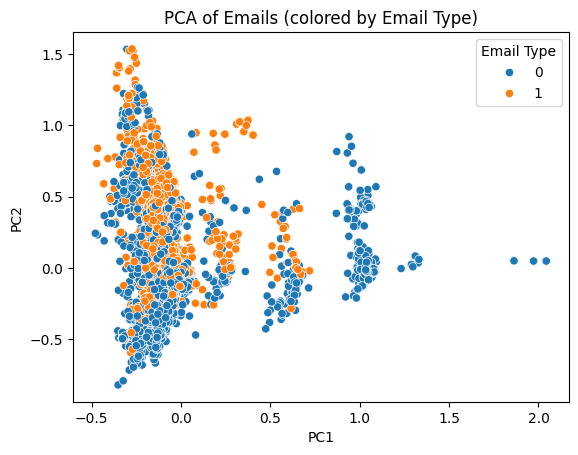

In [87]:
# plot the first two principal components in a scatter plot (hue by email type) 

pca_df = pd.DataFrame({
    'PC1': transformed.iloc[:, 0],
    'PC2': transformed.iloc[:, 1],
    'Email Type': y.reset_index(drop=True)
})
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Email Type')
plt.title('PCA of Emails (colored by Email Type)')
plt.show()

Patterns:

There seems to be a decent amount of overlapping in this scatterplot, indicating that more more components may be necessary (maybe PC2 and PC3). There is, however, a clustering of phishing emails at the low PC1 end. Another possibility is that this data should be looked at on something other than a linear model. 

### Q4.

Run a linear regression of $y$ on the first 2,610 principal components of $X$. What is the $R^2$ on the training and test sets? (I used cross validation to determine that 2,610 was approximately optimal, but not all 2,711 components.)

How does this performance compare to the linear regression?

In [90]:
from sklearn.decomposition import PCA # Import PCA class

pca = PCA(n_components = 2610) # Create PCA instance
pca.fit(X_train)
X_train_pca= pca.transform(X_train) # Project pretrial data; could use new data or test data
X_test_pca = pca.transform(X_test)

model = LinearRegression()
model.fit(X_train_pca, y_train)

r2_train = model.score(X_train_pca, y_train)
r2_test = model.score(X_test_pca, y_test)

print("R squared for the train set = ",r2_train)
print("R squared for the test set = ",r2_test)


R squared for the train set =  0.766896761127783
R squared for the test set =  0.6613559301353324


This performance has a higher R squared value, which is better. This shows that running a linear regression of y on the first 2610 components of X rather than the linear regression from befors is more optimal and a better method. R squared values are ideally as close to 1 as possible.

### Q5.

Explain briefly in your own words what the advantage is in using the principal components to run this high-dimensional regression, rather than the original data.

The advantage of using principal components to run this high-dimensional regression rather than just the original data is that it addresses the issues related to colonearity within the features, that can lead to problems with multi-colinearity and bad control. Essentially, looking at such a large number of words as a way to predict whether or not an email is phishing is unideal because there is a lot of colinearity and correlation among various words. Thus, using PCA reduces the dimensions of the data to capture the main variation in the original set. 